<a href="https://colab.research.google.com/github/abidiDev/.net/blob/main/tunisian_property_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>HOUSE PRICE PREDICTION</h1></center>

<center><img src= "https://cdn.pixabay.com/photo/2016/11/18/17/46/house-1836070__480.jpg"></center>

# Getting Started

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import warnings
warnings.filterwarnings(action='ignore')



```
# Ce texte est au format code
```

# Loading the Dataset


In [ ]:
data = pd.read_csv('../Property Prices in Tunisia.csv')

# Quick Glance at the Dataset


In [ ]:
data

,category,room_count,bathroom_count,size,type,price,city,region,log_price
0,Terrains et Fermes,-1.0,-1.0,-1.0,À Vendre,100000.0,Ariana,Raoued,5.000000
1,Terrains et Fermes,-1.0,-1.0,-1.0,À Vendre,316000.0,Ariana,Autres villes,5.499687
2,Appartements,2.0,1.0,80.0,À Louer,380.0,Ariana,Autres villes,2.579784
3,Locations de vacances,1.0,1.0,90.0,À Louer,70.0,Ariana,Autres villes,1.845098
4,Appartements,2.0,2.0,113.0,À Vendre,170000.0,Ariana,Ariana Ville,5.230449
...,...,...,...,...,...,...,...,...,...
12743,Terrains et Fermes,-1.0,-1.0,-1.0,À Vendre,3200000.0,Tunis,Sidi Bou Said,6.505150
12744,Appartements,1.0,1.0,100.0,À Louer,600.0,Tunis,Autres villes,2.778151
12745,Maisons et Villas,3.0,1.0,760.0,À Vendre,1950000.0,Tunis,La Marsa,6.290035
12746,Maisons et Villas,3.0,1.0,190.0,À Vendre,240000.0,Tunis,La Marsa,5.380211


In [ ]:
#Statistical description
data.describe()

,room_count,bathroom_count,size,price,log_price
count,12748.000000,12748.000000,12748.000000,1.274800e+04,12748.000000
mean,1.759649,0.759884,130.896219,1.601575e+07,4.374245
std,2.171468,1.264812,184.074990,1.016644e+09,1.389788
min,-1.000000,-1.000000,-1.000000,1.000000e+01,1.000000
25%,-1.000000,-1.000000,-1.000000,8.500000e+02,2.929419
50%,2.000000,1.000000,95.000000,8.975000e+04,4.953033
75%,3.000000,1.000000,150.000000,2.600000e+05,5.414973
max,20.000000,10.000000,2000.000000,1.000000e+11,11.000000


In [ ]:
#Null Values
data.isnull().sum()

category          0
room_count        0
bathroom_count    0
size              0
type              0
price             0
city              0
region            0
log_price         0
dtype: int64

We can see that :
The presence of -1 as a value => It is NULL value
The number of -1 values is equal in 3 columns
The presence of outliers in the data
The 'price' varies from 100 to 10e+11, and we can explain it using the fact that our data contains propoerties that are for 'Rent' (À Louer) and for 'Sale' (À Vendre) in the 'type' column


#Data visualisation

#variable analysis


In [ ]:
def plotPerColumnDistribution(data1, nRows, nGraphPerRow):
    track = [[0]*nGraphPerRow]*nRows
    columnNames = data1.columns
        
    fig, ax = plt.subplots(nrows=nRows, ncols=nGraphPerRow, figsize=(20,10))
       
    row, col, i = 0,0,0
    while i<(len(columnNames)):
        if col<=nGraphPerRow-1:
            print(columnNames[i])
            valueCounts = data[columnNames[i]].value_counts().sort_index()
            valueCounts.plot(kind='bar', ax=ax[row][col])
            plt.ylabel('counts')
            plt.xticks(rotation = 90)
            ax[row][col].set_title(columnNames[i])
            col+=1
        else:
            col=0
            row+=1
            i-=1
        i+=1
            
    for j in range(col,nGraphPerRow):
        fig.delaxes(ax[row][j])
    
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [ ]:
data.columns

NameError: ignored

In [ ]:
data1 = data[["room_count", "bathroom_count", "category","type","city"]]
plotPerColumnDistribution(data1,2,3) 

## Insights:
1. __"room_count"__: Most of the houses contains 2 room (1.759649	 on average),except few houses having bedrooms less than 0 and the count goes up to 14 room, now this can be treated as outliers, but considering the fact that these can be some kind of luxerious houses let's keep these and see how our model is performing.

2. __"Bathroom"__: Most of the houses contains 1 room (0.759884		 on average),except few houses having bathrooms less than 0 and the count goes up to 5 bathroom, now this can be treated as outliers, but considering the fact that these can be some kind of luxerious houses let's keep these and see how our model is performing.
3. __"category"__: most present category are appartements, houses and ground , that explain the need of tunisian polulation.
    
4. __"type"__: the majority of people looks for buying instead of renting real Estate .

5. __"city"__: most of real Estate are located in major cities thanks to the disponibilty of social services and jobs .



# Outlier Analysis

In [ ]:
def plotBoxPlot(data1, nRows, nGraphPerRow):
    track = [[0]*nGraphPerRow]*nRows
    columnNames = data1.columns
        
    fig, ax = plt.subplots(nrows=nRows, ncols=nGraphPerRow, figsize=(20,10))
       
    row, col, i = 0,0,0
    while i<(len(columnNames)):
        if col<=nGraphPerRow-1:
            sns.boxplot(data[columnNames[i]],ax=ax[row][col])
            col+=1
        else:
            col=0
            row+=1
            i-=1
        i+=1
            
    for j in range(col,nGraphPerRow):
        fig.delaxes(ax[row][j])
    
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

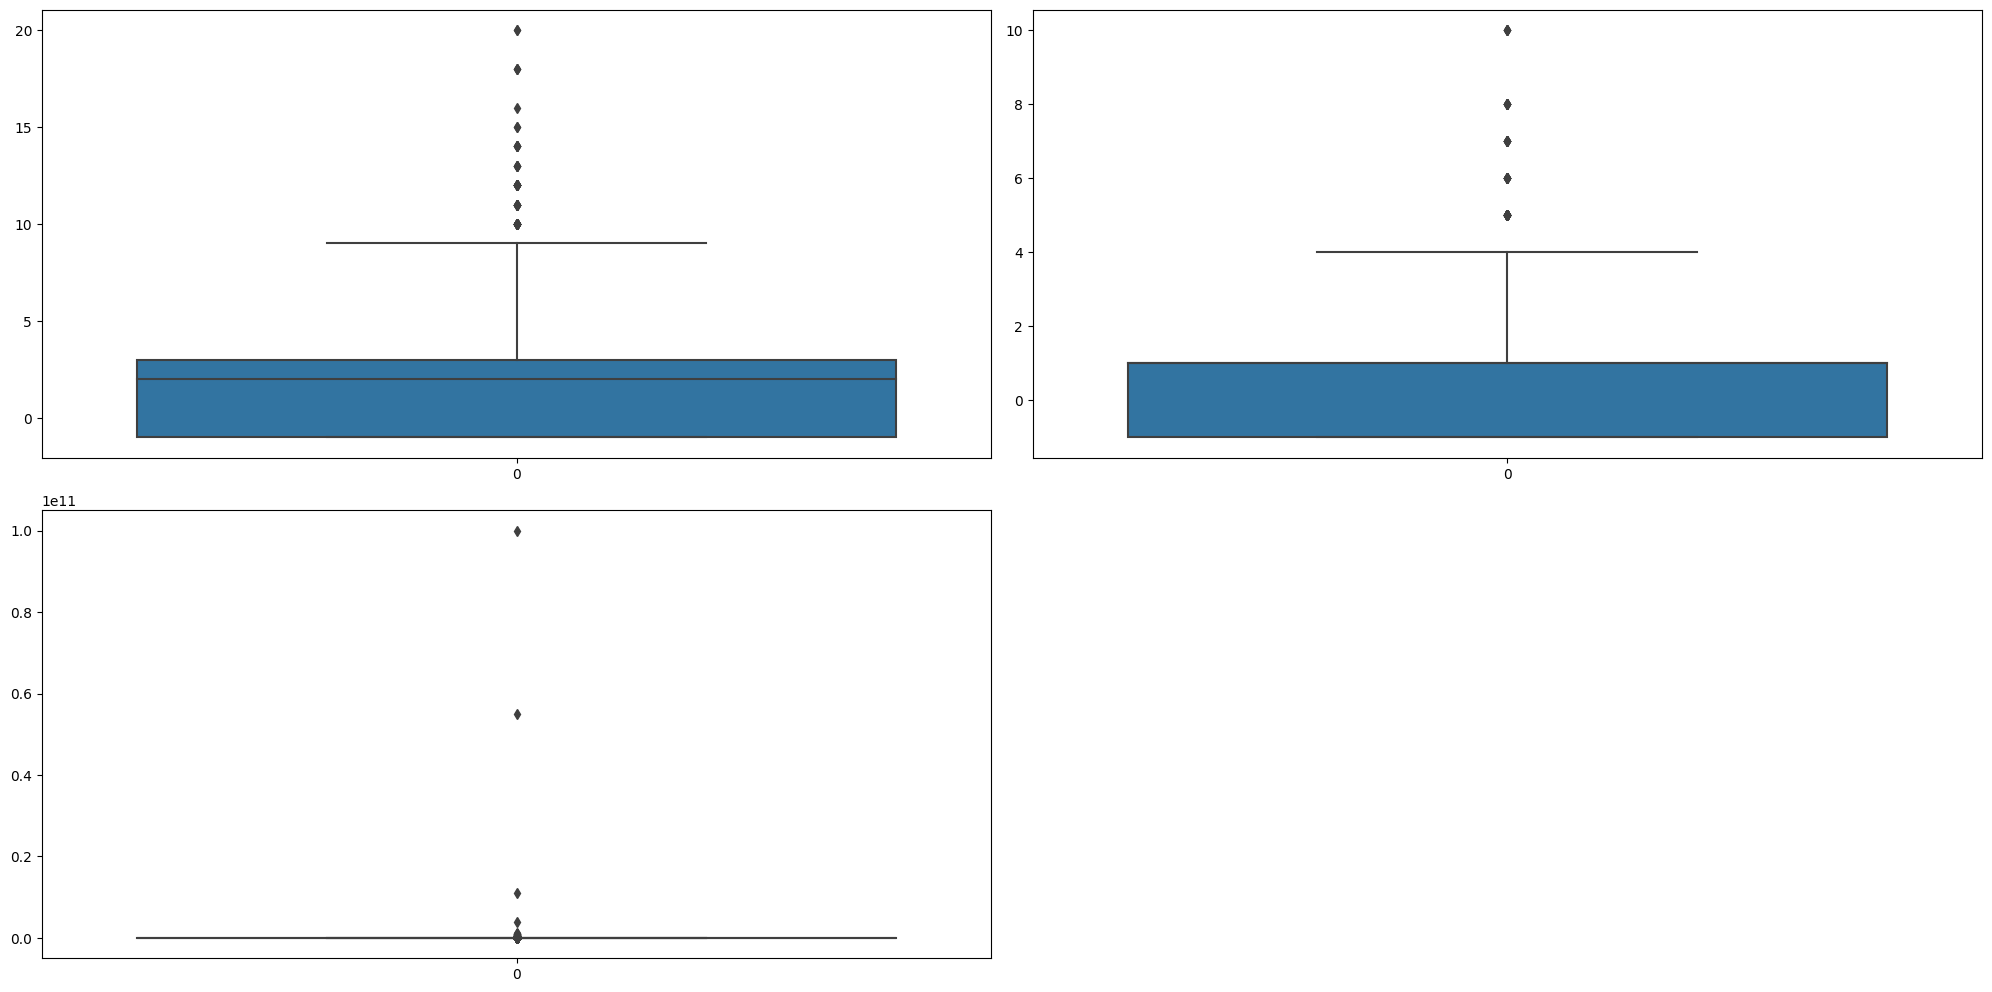

In [ ]:
data1 = data[["room_count", "bathroom_count", "price"]]
plotBoxPlot(data1,2,2) 

#insights

# Preprocessing

In [ ]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Encode missing values properly
    df = df.replace(-1, np.NaN)
    
    # Fill missing values with column medians
    for column in ['room_count', 'bathroom_count', 'size']:
        df[column] = df[column].fillna(df[column].median())
    
    # Binary encoding
    df['type'] = df['type'].replace({'À Louer': 0, 'À Vendre': 1})
    
    # One-hot encoding
    for column in ['category', 'city', 'region']:
        dummies = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    
    # Drop log_price column
    df = df.drop('log_price', axis=1)
    
    # Split df into X and y
    y = df['price']
    X = df.drop('price', axis=1)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test

**One-hot encoding**: One-hot encoding is a technique used to represent categorical data as binary vectors, where each vector element corresponds to a unique category. This is done by creating a new binary variable for each possible category and setting the value to 1 if the original variable has that category, and 0 otherwise.

**Scale X:** Feature scaling is a preprocessing step that standardizes the range of values of the input variables (i.e., the features) so that they have zero mean and unit variance. This can be important for some machine learning algorithms that are sensitive to the scale of the input features. 

In [ ]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [ ]:
X_train

,room_count,bathroom_count,size,type,category_Appartements,category_Bureaux et Plateaux,category_Colocations,category_Locations de vacances,"category_Magasins, Commerces et Locaux industriels",category_Maisons et Villas,...,region_Tozeur,region_Tunis,region_Téboulba,region_Téboursouk,region_Utique,region_Zaghouan,region_Zaouit-Ksibat Thrayett,region_Zarzis,region_Zarzouna,region_Zéramdine
83,-0.594847,-0.415569,-0.526100,-1.240965,-0.762766,-0.195968,13.321411,-0.15142,-0.233407,-0.575323,...,-0.055091,-0.113253,-0.018339,-0.014973,-0.02594,-0.086323,-0.066256,-0.023678,-0.021177,-0.010587
1917,-0.594847,1.004080,-0.377567,-1.240965,-0.762766,-0.195968,-0.075067,-0.15142,-0.233407,1.738154,...,-0.055091,-0.113253,-0.018339,-0.014973,-0.02594,-0.086323,-0.066256,-0.023678,-0.021177,-0.010587
7857,0.122329,-0.415569,-0.139914,-1.240965,-0.762766,-0.195968,-0.075067,-0.15142,-0.233407,1.738154,...,-0.055091,-0.113253,-0.018339,-0.014973,-0.02594,-0.086323,-0.066256,-0.023678,-0.021177,-0.010587
5044,-0.594847,-0.415569,-0.377567,-1.240965,-0.762766,5.102881,-0.075067,-0.15142,-0.233407,-0.575323,...,-0.055091,-0.113253,-0.018339,-0.014973,-0.02594,-0.086323,-0.066256,-0.023678,-0.021177,-0.010587
2726,0.122329,-0.415569,-0.258740,-1.240965,1.311018,-0.195968,-0.075067,-0.15142,-0.233407,-0.575323,...,-0.055091,-0.113253,-0.018339,-0.014973,-0.02594,-0.086323,-0.066256,-0.023678,-0.021177,-0.010587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,-1.312023,-0.415569,-0.852872,0.805824,-0.762766,-0.195968,-0.075067,-0.15142,4.284361,-0.575323,...,-0.055091,-0.113253,-0.018339,-0.014973,-0.02594,-0.086323,-0.066256,-0.023678,-0.021177,-0.010587
905,-1.312023,-0.415569,-0.454804,-1.240965,1.311018,-0.195968,-0.075067,-0.15142,-0.233407,-0.575323,...,-0.055091,-0.113253,-0.018339,-0.014973,-0.02594,-0.086323,-0.066256,-0.023678,-0.021177,-0.010587
5192,-0.594847,-0.415569,-0.585513,-1.240965,-0.762766,5.102881,-0.075067,-0.15142,-0.233407,-0.575323,...,-0.055091,-0.113253,-0.018339,-0.014973,-0.02594,-0.086323,-0.066256,-0.023678,-0.021177,-0.010587
12172,0.122329,-0.415569,-0.377567,-1.240965,-0.762766,-0.195968,-0.075067,-0.15142,-0.233407,1.738154,...,-0.055091,-0.113253,-0.018339,-0.014973,-0.02594,-0.086323,-0.066256,-0.023678,-0.021177,-0.010587


In [ ]:
y_train

83           130.0
1917         550.0
7857         600.0
5044         700.0
2726         600.0
           ...    
10955    8000000.0
905          800.0
5192         450.0
12172        500.0
235       210000.0
Name: price, Length: 8923, dtype: float64

# Training

In [ ]:
models = {
    "                     Linear Regression": LinearRegression(),
    " Linear Regression (L2 Regularization)": Ridge(),
    " Linear Regression (L1 Regularization)": Lasso(),
    "                   K-Nearest Neighbors": KNeighborsRegressor(),
    "                        Neural Network": MLPRegressor(),
    "                         Decision Tree": DecisionTreeRegressor(),
    "                         Random Forest": RandomForestRegressor(),
    "                     Gradient Boosting": GradientBoostingRegressor()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

                     Linear Regression trained.
 Linear Regression (L2 Regularization) trained.
 Linear Regression (L1 Regularization) trained.
                   K-Nearest Neighbors trained.
                        Neural Network trained.
                         Decision Tree trained.
                         Random Forest trained.
                     Gradient Boosting trained.


# Models evaluation

In [ ]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    rmse = np.sqrt(np.mean((y_test - y_pred)**2))
    print(name + " RMSE: {:.2f}".format(rmse))

                     Linear Regression RMSE: 284435794926120173568.00
 Linear Regression (L2 Regularization) RMSE: 1618496260.65
 Linear Regression (L1 Regularization) RMSE: 1618365373.29
                   K-Nearest Neighbors RMSE: 1641085396.37
                        Neural Network RMSE: 1617133672.25
                         Decision Tree RMSE: 1619232076.02
                         Random Forest RMSE: 1618973920.05
                     Gradient Boosting RMSE: 1618062582.56


In [ ]:
for name, model in models.items():
    r2 = model.score(X_test, y_test)
    print(name + " R^2: {:.4f}".format(r2))

                     Linear Regression R^2: -30946436182187188420608.0000
 Linear Regression (L2 Regularization) R^2: -0.0020
 Linear Regression (L1 Regularization) R^2: -0.0018
                   K-Nearest Neighbors R^2: -0.0302
                        Neural Network R^2: -0.0003
                         Decision Tree R^2: -0.0029
                         Random Forest R^2: -0.0026
                     Gradient Boosting R^2: -0.0015


In [ ]:
for name, model in models.items():
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  


MAE: 33925973.03413082
MAE: 33925973.03413082
MAE: 33925973.03413082
MAE: 33925973.03413082
MAE: 33925973.03413082
MAE: 33925973.03413082
MAE: 33925973.03413082
MAE: 33925973.03413082


In [ ]:
for name, model in models.items():
    print('MSE:', metrics.mean_squared_error(y_test, y_pred)) 


MSE: 2.6181265210672077e+18
MSE: 2.6181265210672077e+18
MSE: 2.6181265210672077e+18
MSE: 2.6181265210672077e+18
MSE: 2.6181265210672077e+18
MSE: 2.6181265210672077e+18
MSE: 2.6181265210672077e+18
MSE: 2.6181265210672077e+18


## Conclusion 